In [11]:
import math
import random
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, clear_output
from pyswmm import Simulation, Subcatchments, Nodes
from scipy.interpolate import interp2d



In [12]:
# SWMM file name, If this file is not in the same folder as the python file, the exact path should be given (its recommended to use same folder for swmm and python files)
name = 'STRASSBERG_10T_120D.inp' 

# raingage file name
raingage_name = "Euler_II_10T_120D.dat" 

#report file name (same name as swmm file name but diffrent extention)
rpt= "STRASSBERG_10T_120D.rpt" 

## Functions used

In [13]:
# returns all node IDs for given SWMM file
def node_id (name):
    with Simulation(name) as sim:
        node_id = pd.DataFrame(columns=["Node_ID", "Elevation"])
        for node in Nodes(sim):
            new_data = {"Node_ID": node.nodeid, "Elevation": node.invert_elevation, "OUTFALL":node.is_outfall()}
            node_id = node_id.append(new_data, ignore_index=True)
    return node_id

# to find charachteristic of the cachtment a
def subcatchments_char (name):
    subcatchment_id = pd.DataFrame(columns=["Subcatchment_ID", "Area","Imperv_percentage", "connected_to", "Connected_nodeid"])
    with Simulation(name) as sim:
        subcatchments = Subcatchments(sim)
        for subcatchment in subcatchments:
            new_data = {"Subcatchment_ID": subcatchment.subcatchmentid, "Area": subcatchment.area,"Imperv_percentage":subcatchment.percent_impervious,  "connected_to": subcatchment.connection[0] , "Connected_nodeid":subcatchment.connection[1]}
            subcatchment_id = subcatchment_id.append(new_data, ignore_index = True)
    return(subcatchment_id)

def total_imperv_area (name):
    sub_char = subcatchments_char(name)
    return sub_char.groupby('Connected_nodeid')["Area"].sum().to_frame(name = 'connected catchment area [ha]').reset_index()


# to find line number for a given phrase
def line_num (name, phrase):
    line_number = "Phrase not found"
    a_file = open(name,"r")
    for number, line in enumerate(a_file):
        if phrase in line:
            line_number = number
            break
            a_file.close()
    return line_number


#to delete specific range of lines in a file
def del_line_range (name, starting_ling, ending_line):
    with open(name, 'r+') as fp:
        lines = fp.readlines()
        fp.seek(0)
        fp.truncate()
        for number, line in enumerate(lines):
            if number not in list(range(starting_ling, ending_line)):
                fp.write(line)
                
def del_line (name, line_number):
    lines = []
    with open(name, 'r') as fp:
        lines = fp.readlines()
    with open(name, 'w') as fp:
        for number, line in enumerate(lines):
            if number != line_number:
                fp.write(line)

                
# to check if the string exist in the file 
def check_if_string(name, string_to_search):
    with open(name, 'r') as read_obj:
        for line in read_obj:
            if string_to_search in line:
                return True
    return False 


def search_string_betweentwo(name, string_to_search, minim, maxim):
    line_nu = 0
    line_number = 0
    list_of_results = []
    with open(name, 'r') as read_obj:
        for line in read_obj:
            line_number += 1
            if string_to_search in line:
                if minim<line_number < maxim:
                    list_of_results.append((line_number))
                    line_nu = line_number
    return line_nu-1


def linenumber_junction (name, string):
    st= line_num(name, "[JUNCTIONS]")
    en= line_num(name, "[OUTFALLS]")
    return search_string_betweentwo (name, string, st, en)

#add a new line in a certian location in a text file
def insert_new_line (name, index, content):
    with open(name, "r") as f:
        contents = f.readlines()
    contents.insert(index, "\n")
    contents.insert(index, content)
    with open(name, "w") as f:
        f.writelines(contents)

        
def insert_multiple_line (name, index, content):
    ind = index
    with open(name, "r") as f:
        contents = f.readlines()
    for num in content:
        #contents.insert(ind, "\n")
        contents.insert(ind, num)
        ind += 1
    with open(name, "w") as f:
        f.writelines(contents)
        
def select_data_range (name, fromm, to):
    with open(name, 'r') as fp:
        x = fp.readlines()[fromm:to]
        return x

# to find maximum flooding for one noode
def node_max_flood (name, node_id):

    flood = pd.DataFrame(columns=["Node_ID", "flood"])
    max_flood = pd.DataFrame(columns=["Node_ID", "flood"])

    with Simulation(name) as sim:
        j = Nodes(sim)[str(node_id)]
        for step in sim:
            if j.flooding > 1:
                j_flood = {"Node_ID": j.nodeid, "flood": j.flooding}
                flood = flood.append(j_flood, ignore_index=True)
    maxflood =  {"Node_ID": j.nodeid, "flood": flood['flood'].max() }
    max_flood = max_flood.append(maxflood, ignore_index=True)
    return max_flood


# to add raingage path or name to swwm file
def add_raingage (file_name, raingage_name):
    del_line_range(file_name,line_num(file_name, "[RAINGAGES]")+1, line_num(file_name, "[SUBCATCHMENTS]") )
    new_line = f"LO VOLUME 0:05 1.0 FILE {raingage_name} LO MM \n"
    insert_new_line(file_name, line_num(file_name, "[RAINGAGES]")+1, new_line)
    
    
#to find maximum flood for all nodes
def allnodes_max_flood (name):

    all_nodes = node_id(name)
    all_nodes_max_flood= pd.DataFrame(columns=["Node_ID", "flood"])
    for ind in all_nodes.index:
        max_flood = node_max_flood(name, all_nodes['Node_ID'][ind])
        all_nodes_max_flood = all_nodes_max_flood.append(max_flood, ignore_index=True)
    all_nodes_max_flood=all_nodes_max_flood.dropna()
    return all_nodes_max_flood


#to convert selected object data type to a dataframe with float data type
def to_dataframe_dtype (orig, dic_columns_dtype):
    splited = []
    for elem in orig:
        splited.append(elem.split())
    return pd.DataFrame(splited, columns = list(dic_columns_dtype.keys())).astype(dic_columns_dtype)


def run_model(name):
    with Simulation(name) as sim:
        for step in sim:
            pass
        sim.report()

        
# to read maximum flood for all nodes from rpt file
def read_max_flood (name_of_rpt_file):
    run_model(name)
    f= open(rpt, 'r')
    lines= f.readlines()
    idx_ini= line_num(name_of_rpt_file, 'Node Flooding Summary\n' )
    if check_if_string(name_of_rpt_file, "Storage Volume Summary"):
        idx_end= line_num(name_of_rpt_file, "Storage Volume Summary")-1
    else:
        idx_end= line_num(name_of_rpt_file, 'Outfall Loading Summary\n')-1
    column_type = {'Node': str, 'HoursFlooded': float , 'Maximum_rate_LPS': float, "days": float, "hours": float, "min": float,  "Total_flood_volume": float, "Maximum_ponded_depth_meters": float}        
    d = []
    if lines[idx_ini+3] == '  No nodes were flooded.\n':
        d.append(0)
        return pd.DataFrame(d, columns =['Total_flood_volume'])
    else:
        for i in select_data_range(name_of_rpt_file, idx_ini+10, idx_end):
            d.append(i.replace(":", " "))
            df = to_dataframe_dtype(d, column_type).dropna()
            df["Total_flood_volume"] = 1000000 * df["Total_flood_volume"]
    return df
            


def read_conduites (name):
    f= open(name, 'r')
    lines= f.readlines()
    idx_ini= line_num(name, "[CONDUITS]" )+1
    idx_end= line_num(name, "[XSECTIONS]")-1
    if 'Name' in lines[idx_ini]:
        idx_ini = idx_ini+3
    d= []
    for i in select_data_range(name, idx_ini, idx_end):
        d.append(i.split())
    column_type = {'Name': str, 'From_Node': str , 'To_Node': str, "Lenght": float, "Roughness": float, "InOffset": float,  "OutOffset": float, "InitFlow": float, "Maxflow":float}        
    return pd.DataFrame(d, columns = list(column_type.keys())).astype(column_type)


def find_all_paths (node_index):
    index = node_index
    f_path = []
    ini = []
    ini.append(conduites.loc[index]["To_Node"])
    f_path.append(ini)
    ind = 0
    count = 0
    n = 0
    #to find all paths
    while n<=len(f_path):
        c = -1
        for i in f_path: 
            c=c+1
            if i[-1] in word_count:   
                flow_from= []
                if word_count [f_path[c][-1]] == 2:
                    L2= f_path[c].copy()
                    flow_from.append(conduites.loc[conduites.index[conduites['To_Node']== f_path[c][-1]]]["From_Node"].to_list())
                    f_path[c].append(flow_from[0][0])
                    L2.append(flow_from[0][1])
                    f_path.append(L2)
                elif word_count [f_path[c][-1]] == 1:
                    flow_from.append(conduites.loc[conduites.index[conduites['To_Node']== f_path[c][-1]]]["From_Node"].to_list())
                    f_path[c].append(flow_from[0][0])
            else:
                pass
        n=n+1 
    return(f_path)


#to find th longest path and the total upstraim area
def total_area_lenght (f_path, sub_area): 
    total_lenght= []
    area_from =[]
    area = []
    for l in f_path:
        lenghts = []
        z=0
        for n in l:
            if n not in area_from:
                area_from.append(n)
                area.extend((sub_area.loc[sub_area.index[sub_area['Connected_nodeid']== n]]["connected catchment area [ha]"]))
            if z != 0:
                lenghts.extend((conduites.loc[conduites.index[conduites['From_Node']== n]]["Lenght"].to_list()))
            z=z+1
        lenghts_sum = sum(lenghts)
        total_lenght.append(lenghts_sum)
    total_lenght 
    area_from
    sum(area)
    total_lenght
    longest_path = f_path[total_lenght.index(max(total_lenght))]
    longest_path_lenght = max(total_lenght)
    total_area= sum(area)
    return (longest_path, longest_path_lenght, total_area)


def total_area_lenght_all (name):
    sub_area= total_imperv_area(name)
    conduites = read_conduites(name)
    word_count= pd.value_counts(conduites['To_Node'])
    longest_path= []
    longest_path_lenght = []
    total_area = []  
    for nodes in range(len(sub_area["Connected_nodeid"])):
        f_path = find_all_paths(nodes)
        c = total_area_lenght(f_path, sub_area)
        longest_path.append (c[0])
        longest_path_lenght.append (c[1])
        total_area.append (c[2])
    return sub_area.assign(longest_path =longest_path, longest_path_lenght=longest_path_lenght, total_area = total_area)



def rain_depth (return_period,rain_duration):
    c_5 = pd.read_excel('C.5.xlsx')
    t_n = list(c_5.columns.values)
    x = t_n[1:]
    y = c_5["Return period Tn [a]:"].to_list()
    z = []
    for index, row in c_5.iterrows():
        z.append(list(row[1:]))
    f = interp2d(x,y,z, kind = "linear", fill_value="-1")
    rain_depth = []
    if rain_duration in y:
        y_indx = y.index(rain_duration)+1
    else:
        y.append(rain_duration)
        y.sort()
        y_indx = y.index(rain_duration)+1
    for i in y[:y_indx]:
        rain_depth.append(f(return_period, i)[0])
    return (y[:y_indx], rain_depth)


def storage_area_design (safety_factor, return_period, rain_duration, hight):
#input
    #safety_factor = 1.2 klk
    #return_period = 5
    #rain_duration = 240

    n = 1/return_period
    travel_time = 20
    
    rain_depth_mm=rain_depth(return_period, rain_duration)
    area_hectar =total_area_lenght_all(name)
    volume = []
    storage_area_m2 = []
    for m in area_hectar["total_area"]:
        
        runoff_volume_m3 = [i * m*10000/1000 for i in rain_depth_mm[1]]
        #runoff_volume_m3 = [i * 81000/1000 for i in rain_depth_mm[1]]

        q_ls= 2*m
        q_m3m = q_ls*3.6/60
        throttle_volume_m3 = [i * q_m3m for i in rain_depth_mm[0]]
        travel_time_m = 20
        f1 = 1-((1*10**-10*travel_time**3)-(8*10**-9*travel_time**2)+(1*10**-8*travel_time))*q_ls**3+((1.6*10**-8*travel_time**3)-(9.15*10**-7*travel_time**2)+(1.14*10**-6*travel_time))*q_ls**2+((1.8*10**-7*travel_time**3)-(1.25*10**-5*travel_time**2)+(1.56*10**-5*travel_time))*q_ls
        attenuation_factor =  (0.6134*n+0.3866)*f1-(0.6134*n-0.6134)
        #attenuation_factor = 0.98
        
        design_volume = np.subtract(np.array(runoff_volume_m3),np.array(throttle_volume_m3))*safety_factor*attenuation_factor
        design_volume = design_volume.max()
        area = design_volume/hight
        storage_area_m2.append(area)
        volume.append(design_volume)
    return storage_area_m2


#add storage section to .inp file if not existed before
def add_to_inp (section, lower_section, to_add):
    if not check_if_string(name, section):
        insert_new_line(name,line_num(name, lower_section), section )
    #add new STORAGE list to .inp file
    del_line_range(name, line_num(name, section)+1, line_num(name, lower_section) )
    insert_multiple_line(name, line_num(name, section)+1, to_add)
    
    
    
# read the file's contents
def read_inp(name):
    read_file = open(name,'r')
    lines = read_file.readlines()
    read_file.close()
    return lines


def write_inp (name, orig_inp):
    write_file = open(name,'w')
    for line in orignal_inp:
        write_file.write(line)
    write_file.close()

    
    
def storage_curve_design(name,safety_factor, return_period, rain_duration, depth):
    #safety_factor = 1.2 klk
    #return_period = 5
    #rain_duration = 240
    
    storage_nodes = []
    curve_nodes = []
    total_imperv = total_area_lenght_all(name)
    total_imperv.rename(columns = {'Connected_nodeid':"Node_ID"}, inplace = True)
    d =pd.merge(node_id(name), total_imperv, how = "right", on='Node_ID')
    design_storage_area = storage_area_design(safety_factor, return_period, rain_duration, depth )
    #storage_area_design(1.2, 5, 240, 2.5 )
    
    d = d.assign(storage_area=design_storage_area)
    d =d.drop(d.index[d['OUTFALL']== 1]).reset_index()
    for index, row in d.iterrows():
        new_line = f"{row['Node_ID']} STORAGE {depth} {row['storage_area']} \n"
        curve_nodes.append(new_line)
        new_line = f"{row['Node_ID']} {row['Elevation']} {depth} 0 TABULAR {row['Node_ID']} 0 0 \n"
        storage_nodes.append(new_line)
    return (storage_nodes, curve_nodes, d, design_storage_area)


# to find index number for a given phrase
def index_num_phrase (list_name, phrase):
    line_number = "Phrase not found"
    for number, line in enumerate(list_name):
        if phrase in line:
            line_number = number
            break
            a_file.close()
    return line_number


# check if nodes are flooding and calculating total flooding if flooding exist
def sum_flood (rpt):
    nodes_flooded_loop =read_max_flood(rpt)
    if nodes_flooded_loop.iloc[0]['Total_flood_volume'] == 0:
        flood_sum = 0
        best_flood_sum = flood_sum
    else:
        flood_sum = nodes_flooded_loop['Total_flood_volume'].sum()
    return flood_sum

# to get list of indexes from a list
def index_list (list_):
    index_list = []
    for i in range(len(list_)):
        index_list.append(i)
    return index_list

def creat_chromosome_index (selected_storages, storage_design):
    chromosome = []
    chromosome_index = []
    index = -1
    for i in storage_design:
        index+=1
        if i in list(list(selected_storages)):
            chromosome. append (True)
            chromosome_index.append(index)
        else:
            chromosome.append(False)
    return (chromosome, chromosome_index)

def storage_selection_first(storage_design):
    nodes_flooded_loop =read_max_flood(rpt)

    nodes_flooded = total_imperv_area(name)[total_imperv_area(name)["Connected_nodeid"].isin(nodes_flooded_loop['Node'])]
    selected_storages = nodes_flooded
    chromosome_creat = creat_chromosome_index(selected_storages["Connected_nodeid"], storage_design)
    selected_storage_list = [storage_list_for_allnodes[i] for i in chromosome_creat[1]]

    storage_list_for_allnodes_probabilty = []
    for i in storage_list_for_allnodes_index:
        if i in chromosome_creat[1]:
            storage_list_for_allnodes_probabilty.append(50)
        else:
            storage_list_for_allnodes_probabilty.append(50)
    return (selected_storage_list, chromosome_creat, storage_list_for_allnodes_probabilty, selected_storages)


def storage_selection_iter(nodes_flooded_ini, storage_list_for_allnodes_index, storage_list_for_allnodes_probabilty, storage_design):

    number_of_storage= random.randint(len(nodes_flooded_ini),len(nodes_flooded_ini)+3)
    Set = set(storage_list_for_allnodes_index)
    selected_storages_index =list(set(random.choices(list(Set),weights= storage_list_for_allnodes_probabilty, k = number_of_storage)))
    selected_storage_list = [storage_list_for_allnodes[i] for i in selected_storages_index] 
    column_type = {'Connected_nodeid': str,  'Elev.': float ,"MaxDepth": float, 'InitDepth': float, "Shape": str, "Curve_Name/Params": str, "N/A": float, "Fevap": float}        
    selected_storages = to_dataframe_dtype(selected_storage_list, column_type )
    chromosome_creat = creat_chromosome_index(selected_storages["Connected_nodeid"], storage_design)
    return(selected_storage_list, chromosome_creat, selected_storages)

#delete assigned storage nodes from juntion list and assign them to a new variabl
def del_storage_from_junction (junction_orig, selected_storages):
    new_junctions = junction_orig.copy()
    storage_index_for_junction = []
    for i in selected_storages["Connected_nodeid"]:
        storage_index_for_junction.append(int(node_id_ini[node_id_ini["Node_ID"]== i].index.values))
    return [i for j, i in enumerate(new_junctions) if j not in storage_index_for_junction]


def creat_population (num):
    

    n=0
    storage_nodes = []
    flood = []
    storage_area_total = []
    chromosom = []
    
    while n<num:
 
        # check if nodes are flooding and calculating total flooding if flooding exist
        flood_sum = sum_flood(rpt)


        if n== 0:
            storages = storage_selection_first(d[2]["Node_ID"])
            selected_storages = storages[3]
            prob = storages[2]
        else:
            storages = storage_selection_iter(nodes_flooded_ini, storage_list_for_allnodes_index, prob, d[2]["Node_ID"])
            selected_storages = storages[2]
        

        storage_nodes.append(selected_storages["Connected_nodeid"])
        flood.append(flood_sum)
        storage_area_total.append(d[2]["storage_area"][storages[1][1]].sum())
        chromosom.append(storages[1][0])
        
        
        pd.set_option('display.max_rows', None, 'display.max_columns', None)

        #delete assigned storage nodes from juntion list and assign them to a new variabl

        new_junctions = del_storage_from_junction(junction_orig, selected_storages)

        add_to_inp("[STORAGE]","[CONDUITS]", storages[0])
        add_to_inp("[JUNCTIONS]","[OUTFALLS]", new_junctions)

        n+=1
        print("Creating Population...")

        ax.set_xlim(-1000, n)    
        ax.cla()
        ax.scatter(flood, storage_area_total, marker='o', label = "Population")
        ax.set_ylim(bottom = -100)

        ax.set_title("Initial Population")
        #ax.set_xlabel (" total flood rate [l/s]")
        ax.set_ylabel("total storage area [m2]")
        ax.legend()
        
        #ax.set_xlim(left = 0, right = 160) 
        display(fig)    
        clear_output(wait = True)
        plt.pause(2) 
    display(fig)
    print("Population created :)")
    write_inp (name, orignal_inp)
    return (storage_nodes, flood, storage_area_total, chromosom)



## Main body of the code and how to costumize it 

In order to run this python code, please download and keep the necessary files at the same folder. Also, its recommended to use the same format of the swmm file used in this example, means don’t change parameters by opening .inp file in swmm software and then save it back. This will add some extra headings to the .inp file and might not be able to read by this code.

 - For the storage tank design, you can use your own configuration by customizing the storage_curve_design function in line 14 which takes the following inputs:

&emsp; storage_curve_design(name of the swmm file, safety_factor, return_period, rain_duration, depth of storage tank)

 - The number of initial populations can be changed using creat_population function in line 50.

 - The number of offspring for each generation can also be set using the input parameter of pop_size of NSGA2 class in line 98


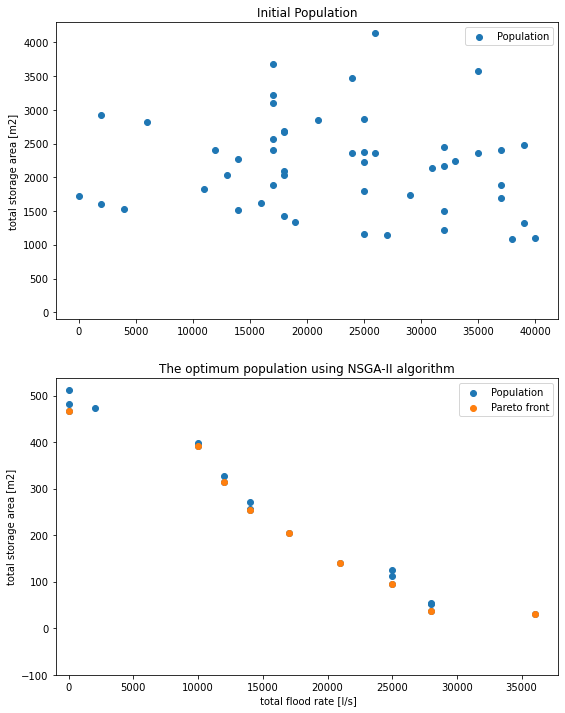

In [10]:
    
#add raingage if the file was opened for the first time 
add_raingage(name, raingage_name) 
# orignal file
conduites = read_conduites(name)
word_count= pd.value_counts(conduites['To_Node'])



# copy of original junctions befor changing them
junction_orig = select_data_range(name, line_num(name, "[JUNCTIONS]")+1, line_num(name, "[OUTFALLS]"))

# create list of all curves and storage designes for all available nodes. storage_curve_design(name of the swmm file,safety_factor, return_period, rain_duration, depth of storage tank)
d = storage_curve_design(name, 1.2, 10, 240, 2.5)
# list of storage design for all nodes avaialble 
storage_list_for_allnodes = d[0]

#add curve to the inp 
add_to_inp("[CURVES]", "[REPORT]", d[1])

#get a copy of original swmm file
orignal_inp = read_inp(name)

#dataframe for nodes which were flooded initialy after first run of the model
nodes_flooded_ini = read_max_flood(rpt)

best_flood_sum = float('inf')

node_id_ini = node_id(name)


# to get list of indexes for available nodes
storage_list_for_allnodes_index = index_list(storage_list_for_allnodes)

# probabilty given to each node to be selected during selection process
storage_list_for_allnodes_probabilty = [] 

print("Creating Population...")

# Plot population 
fig = plt.figure(figsize=(9, 12))
ax = fig.add_subplot(2, 1, 1) 
ax.set_title("Population")



dx = fig.add_subplot(2,1,2)

# Creat initial population based on given population number
population_orig = creat_population (50)

#make a copy of the initial population created
population = deepcopy(population_orig)

population_copy= list(population)



X = np.array(population_copy[3])


from pymoo.algorithms.moo.nsga2 import NSGA2

from pymoo.core.problem import ElementwiseProblem


# Create customized problem class 
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var = 41, 
                         n_obj=2)

    def _evaluate(self, x, out, *args, **kwargs):
        new_child_storage = read_chromosome(x)
        column_type = {'Connected_nodeid': str,  'Elev.': float ,"MaxDepth": float, 'InitDepth': float, "Shape": str, "Curve_Name/Params": str, "N/A": float, "Fevap": float}
        storages_dataFrame = to_dataframe_dtype(new_child_storage[0], column_type )
        storages_id = storages_dataFrame["Connected_nodeid"]
        new_junctions = del_storage_from_junction(junction_orig, storages_dataFrame)
        add_to_inp("[STORAGE]","[CONDUITS]", new_child_storage[0])
        add_to_inp("[JUNCTIONS]","[OUTFALLS]", new_junctions)
        f1 = flood_sum = sum_flood(rpt)
        f2 = storage_area_total=d[2]["storage_area"][new_child_storage[1]].sum()
        write_inp (name, orignal_inp)
        out["F"] = [f1, f2]



problem = MyProblem()

from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.optimize import minimize
from pymoo.termination.ftol import MultiObjectiveSpaceTermination
from pymoo.termination.robust import RobustTermination

# Input parameters for nsga-ii algorithm ( pop_size = offspring size after initial population was created, sampling = Initial population)
algorithm = NSGA2(pop_size= 20, 
                  sampling=X,
                  crossover=TwoPointCrossover(),
                  mutation=BitflipMutation(),
                  eliminate_duplicates=True)

##type of termination criteria, in my case it was I used robust termination ( tol = tolerance value, period = number of consecutive times which indicator value reach lower than the tolerance number)
termination = RobustTermination(MultiObjectiveSpaceTermination(tol=0.05), period=2)

# Type of optimization in this case its minimize, because the both objective functions in this problem should be minimized
res = minimize(problem,
               algorithm,
               termination,
               pf = True,
               seed=1,
               verbose=True, save_history=True)


#to get the optimum population from the result file
pop = res.pop

#to get the pareto-front from the result file
pop.get("F").T[0]

#plot the pareto-front
dx.cla()
dx.scatter(pop.get("F").T[0], pop.get("F").T[1], marker='o', label  = "Population")
dx.set_xlim(left = -1000)
dx.set_ylim(bottom = -100)
dx.set_title("The optimum population using NSGA-II algorithm")
dx.set_ylabel("total storage area [m2]")
dx.set_xlabel (" total flood rate [l/s]")
dx.legend()

display(fig) 
clear_output(wait = True)
plt.pause(1) 

dx.scatter(res.F.T[0], res.F.T[1], marker='o', label = "Pareto front")
dx.legend()
display(fig)




In [127]:
#sive the above figure if needed
fig.savefig('pop_10_5.jpg')

In [138]:
# to make a dataframe and excel file for the pareto-front with their respective Selected nodes as storage-tank, Total flooded volume, and total storage tank area [m2]
pd.set_option('display.max_colwidth', None)
with open('res_5_4.pickle', 'rb') as f:
     res_1_1= pickle.load(f)
all_nodes = []
for i in (res_1_1.X):
    nodes = []
    for n in read_chromosome(i)[0]:
        nodes.append(n.split()[0])
    all_nodes.append(str(nodes))
flooded = pd.DataFrame(all_nodes, columns = ({"Selected nodes as storage tank"}))

flood_v = []
storage_a = []
for f in res_1_1.F:
    flood_v.append(f[0])
    storage_a.append(f[1])
storage_a
flooded["Total flooded volume [L]"] = flood_v
flooded["Total storage tank area [m2]"]= storage_a

flooded.to_excel("flooded_.xlsx")
flooded

,Selected nodes as storage tank,Total flooded volume [L],Total storage tank area [m2]
0,"['1006', '1016', '1017', '1034', '1035']",8000.0,261.261339
1,"['1016', '1034', '1035']",11000.0,229.890225
2,"['1006', '1034', '1036']",26000.0,46.580563
3,"['1006', '1016', '1017', '1034']",19000.0,73.036991
4,"['1006', '1008', '1015', '1016', '1034', '1038']",7000.0,357.343778
5,"['1006', '1014', '1016', '1017', '1034', '1035', '1036']",0.0,399.390333
6,"['1006', '1017']",35000.0,31.371114
7,"['1034', '1035']",13000.0,207.394565


In [137]:
#Calculate frequency of each node being selected in the pareto-front
freq = []
for f in range(0, len(storage_list_for_allnodes)):
    freq.append(0)
for l in res_1_1.X: 
    index = 0
    for i in l:
        if i == True:
            freq[index] +=1
        index +=  1
frequency = np.array(freq)
frequency = frequency/len(res_1_1.X)
frequency

#Path where results are located
path_data= "C:\\Users\\Abullqasim\\Documents\\4th semester\\Thesis\\Model\\"
#frequency_df = d[2][["Node_ID"]].copy()
name_list = d[2]["Node_ID"].tolist()
frequency_df= pd.DataFrame(data=name_list, columns=['ID'])
frequency_df["frequency"]=frequency
#save results as CSV file
frequency_df.to_csv(path_data+'frequencies.csv', sep=',', index= None)
frequency_df

,ID,frequency
0,1000,0.000000
1,1001,0.000000
2,1002,0.000000
3,1003,0.000000
4,1005,0.000000
5,1006,0.666667
6,1007,0.000000
7,1008,0.166667
8,1009,0.333333
9,1010,0.000000
